In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product d.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_d= df.drop(['Product Name','Product Category','Month','Year', 'Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_d.shape

(60, 1)

In [5]:
sales_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_d['Sales'].sum()

7173488

Text(0.5, 1.0, 'Product D')

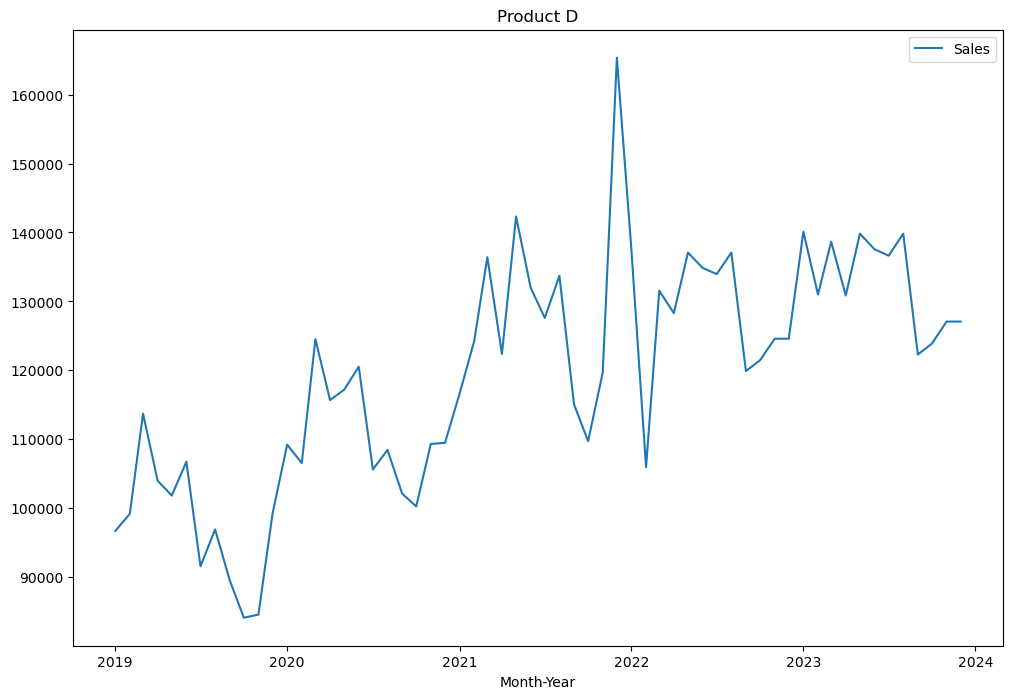

In [7]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_d)
plt.title('Product D')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_d)

ADF Statistics: -2.3249460487083105
p- value: 0.16404854202961083
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_d_diff= sales_d.diff().dropna()

Text(0.5, 1.0, 'Product D- First Difference')

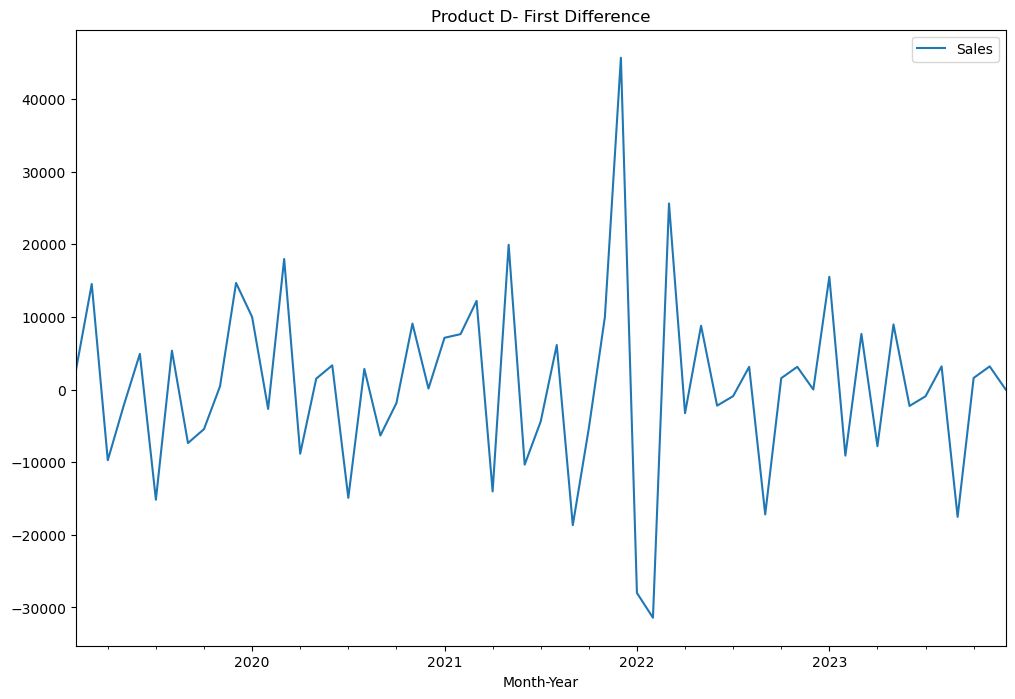

In [11]:
sales_d_diff.plot(figsize=(12,8))
plt.title('Product D- First Difference')

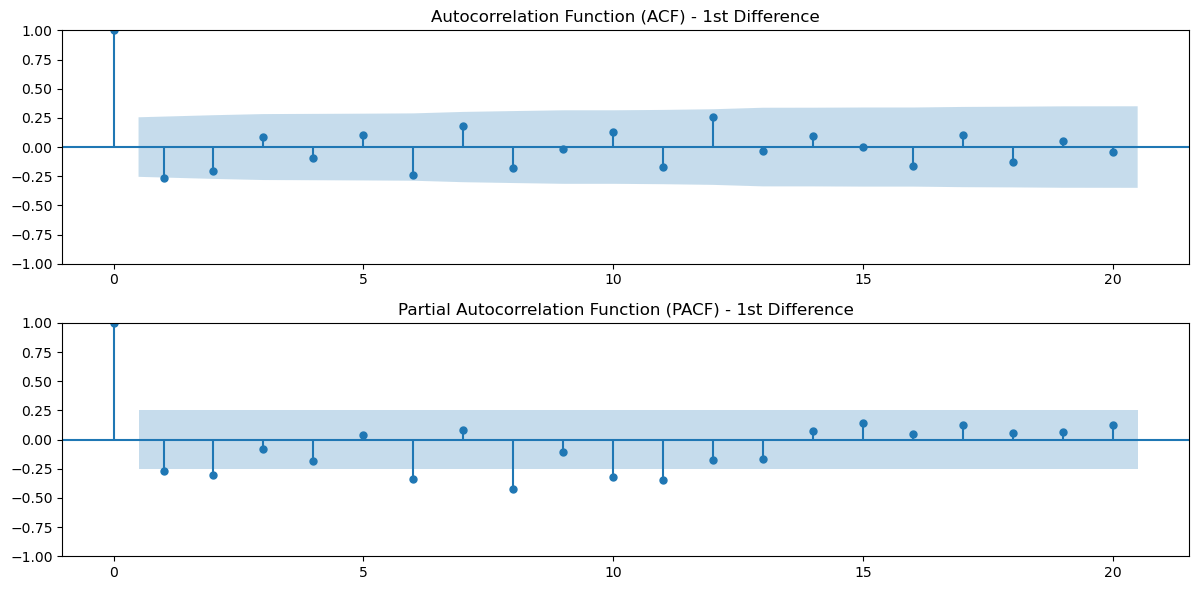

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_d_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_d_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_d_diff)

ADF Statistics: -4.6011480666771325
p- value: 0.00012854172822943823
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_d[:54]
test=sales_d[54:]

In [15]:
print(len(train), len(test))

54 6


In [16]:
# combination p=(1,2,3,4,5) d=1 q=(0,1) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(1,1,0), (1, 1, 1), (2,1,0), (2, 1, 1),(3,1,0), (3, 1, 1),(4,1,0), (4, 1, 1), (5,1,0), (5, 1, 1)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(2):
        # Fit model        
#       model= ARIMA(sales_b, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_d)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic          mae           mse          rmse
0   0  0  1155.095532  1157.065824  8853.166667  1.077347e+08  10379.531902
1   0  1  1155.518262  1159.458846  8958.259220  1.103133e+08  10503.015477
2   1  0  1155.608174  1159.548758  9015.301070  1.116195e+08  10565.011980
3   1  1  1156.561878  1162.472754  7993.858665  8.706086e+07   9330.640834
4   2  0  1157.826372  1163.737248  8825.165594  1.074945e+08  10367.955377
5   2  1  1158.645881  1166.527048  8052.086896  8.833836e+07   9398.848728
6   3  0  1159.563221  1167.444388  8877.462002  1.074691e+08  10366.731704
7   3  1  1160.532641  1170.384101  8011.072402  8.669281e+07   9310.897605
8   4  0  1161.165205  1171.016665  8545.219756  1.006529e+08  10032.589422
11  5  1  1161.252680  1175.044724  7905.579198  8.048771e+07   8971.494425
10  5  0  1162.772551  1174.594302  8437.215680  9.954017e+07   9976.981812
9   4  1  1163.106114  1174.927866  8573.330670  1.010367e+08  10051.699738


In [20]:
m_arima= ARIMA (train, order=(0,1,0))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   54
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -576.548
Date:                Thu, 09 May 2024   AIC                           1155.096
Time:                        16:40:24   BIC                           1157.066
Sample:                    01-01-2019   HQIC                          1155.853
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.615e+08   2.16e+07      7.466      0.000    1.19e+08    2.04e+08
Ljung-Box (L1) (Q):                   4.14   Jarque-Bera (JB):                 9.98
Prob(Q):                              0.04   Pr

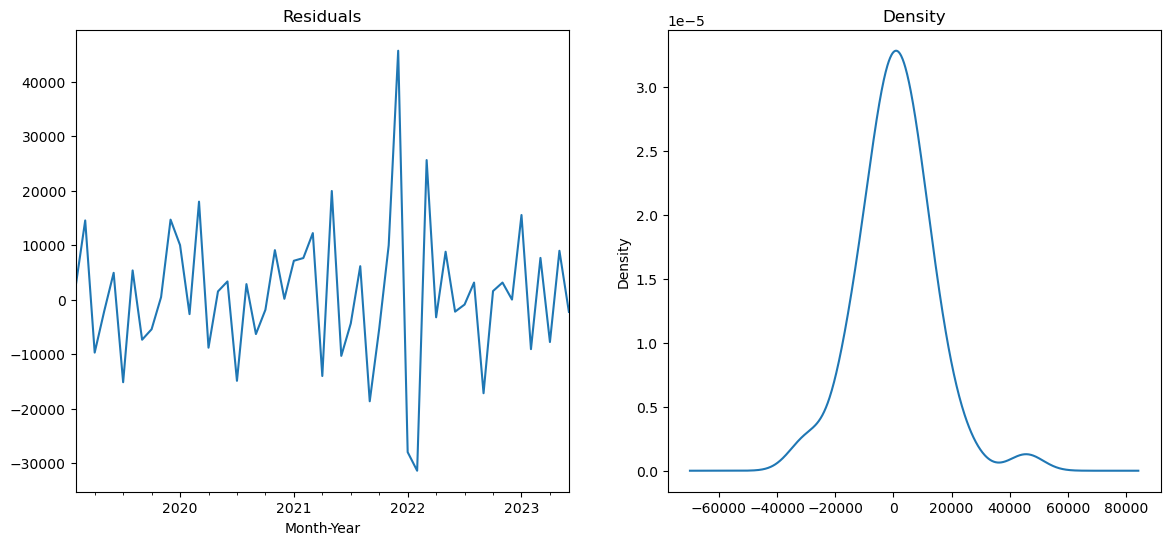

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

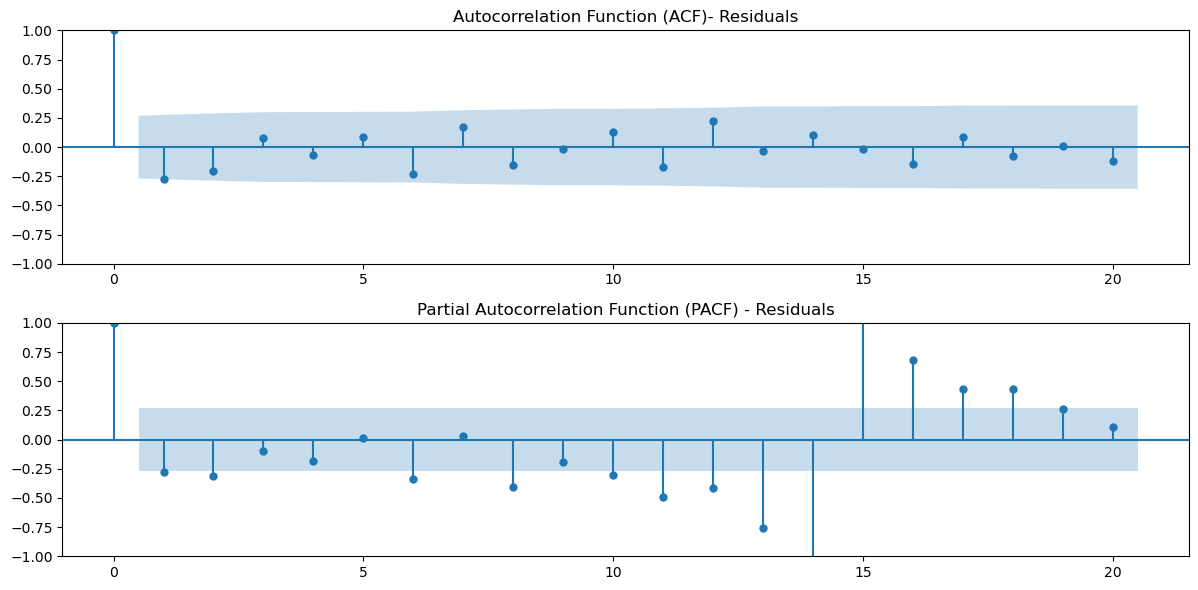

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

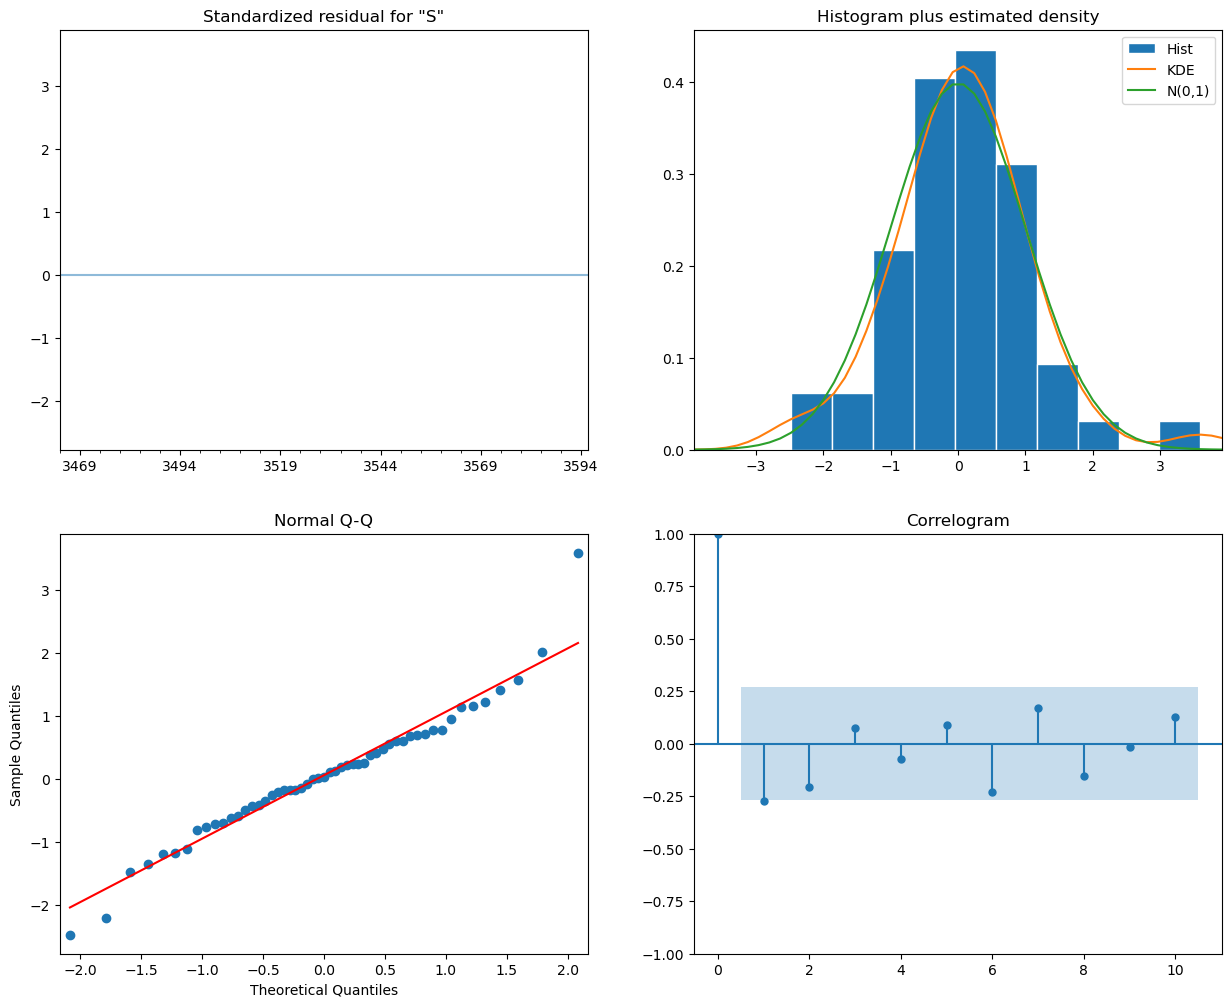

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_d['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_d.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_d)-1), dynamic = True)
sales_d['Forecast_ARIMA']=[None]*len(train) + list(pred)

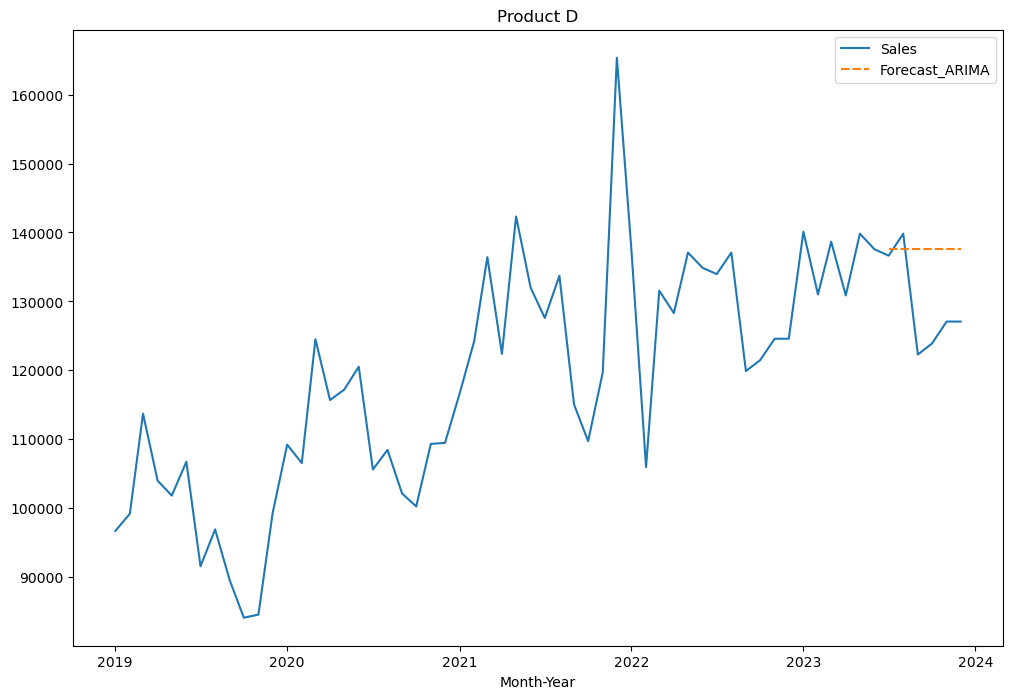

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_ARIMA']])
plt.title('Product D')
plt.show()

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 8853.166666666666
MAPE - ARIMA: 0.07055860107660188
MSE - ARIMA: 107734682.5
RMSE - ARIMA: 10379.531901776689


# SARIMA

In [28]:
import statsmodels.api as sm

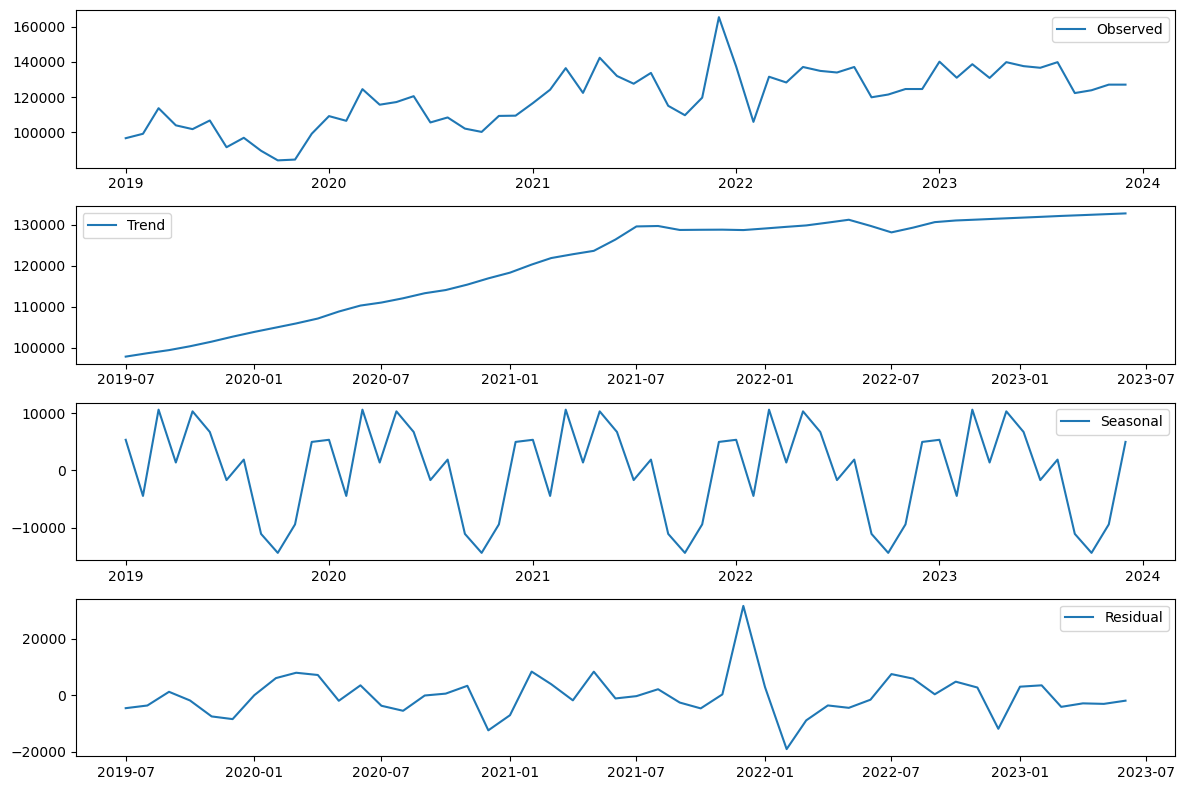

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_d['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

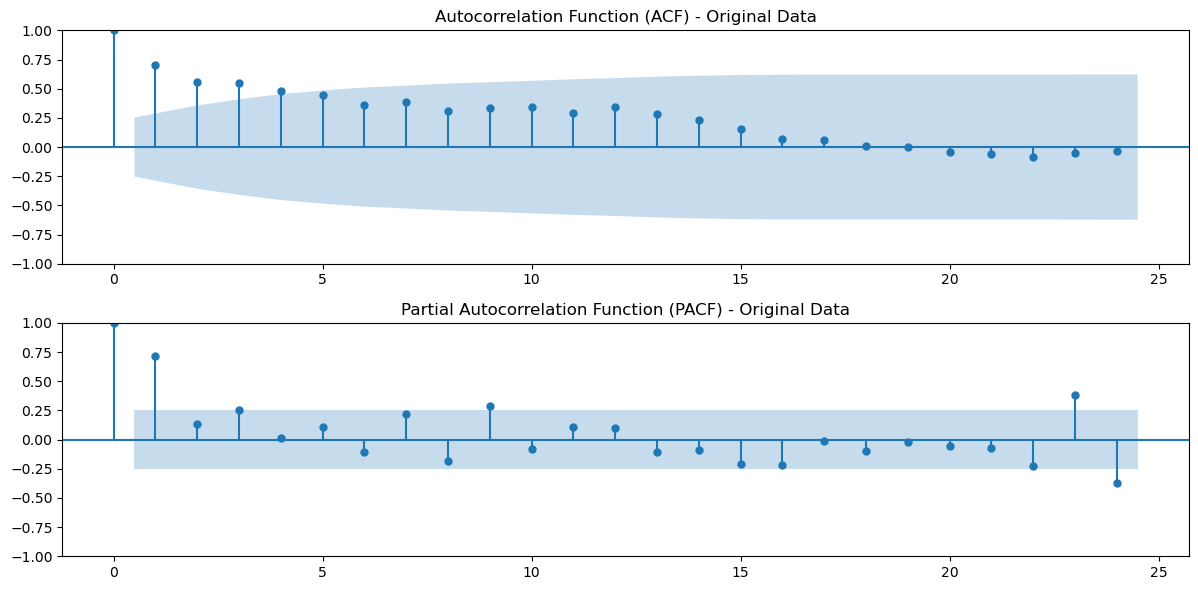

In [30]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_d['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_d['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

In [32]:
order_SARIMAX=[]
# Loop over P order
for P in range(5):
    # Loop over Q order
    for Q in range(4):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(0, 1, 0), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=54, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [33]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q          aic          bic          mae           mse
13  3  1   896.545294   905.113155  3859.539042  3.362324e+07
12  3  0   898.506052   905.360341  3773.784556  1.874422e+07
7   1  3   907.390891   915.958751  3475.125819  2.188357e+07
3   0  3   907.502404   914.356692  2584.614650  2.182085e+07
16  4  0   908.116882   916.684743  3395.896258  1.987348e+07
1   0  1   908.445764   911.872908  4655.926746  3.497377e+07
4   1  0   908.528075   911.955219  4077.531156  5.802370e+07
6   1  2   909.035853   915.890141  5123.131336  5.392026e+07
10  2  2   909.175569   917.743430  3979.082299  3.506712e+07
14  3  2   909.189513   919.470945  3375.805826  1.970791e+07
11  2  3   909.333856   919.615289  3483.755973  2.162691e+07
17  4  1   909.643011   919.924444  3385.466255  1.978397e+07
2   0  2   909.696732   914.837448  3522.446598  2.242012e+07
15  3  3   910.754693   922.749697  3364.514685  1.965507e+07
18  4  2   911.189654   923.184658  3376.223030  1.970810e+07
19  4  3

In [57]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(0, 1, 0),seasonal_order=(1,0,2,12))
sarima_model=sarima.fit()

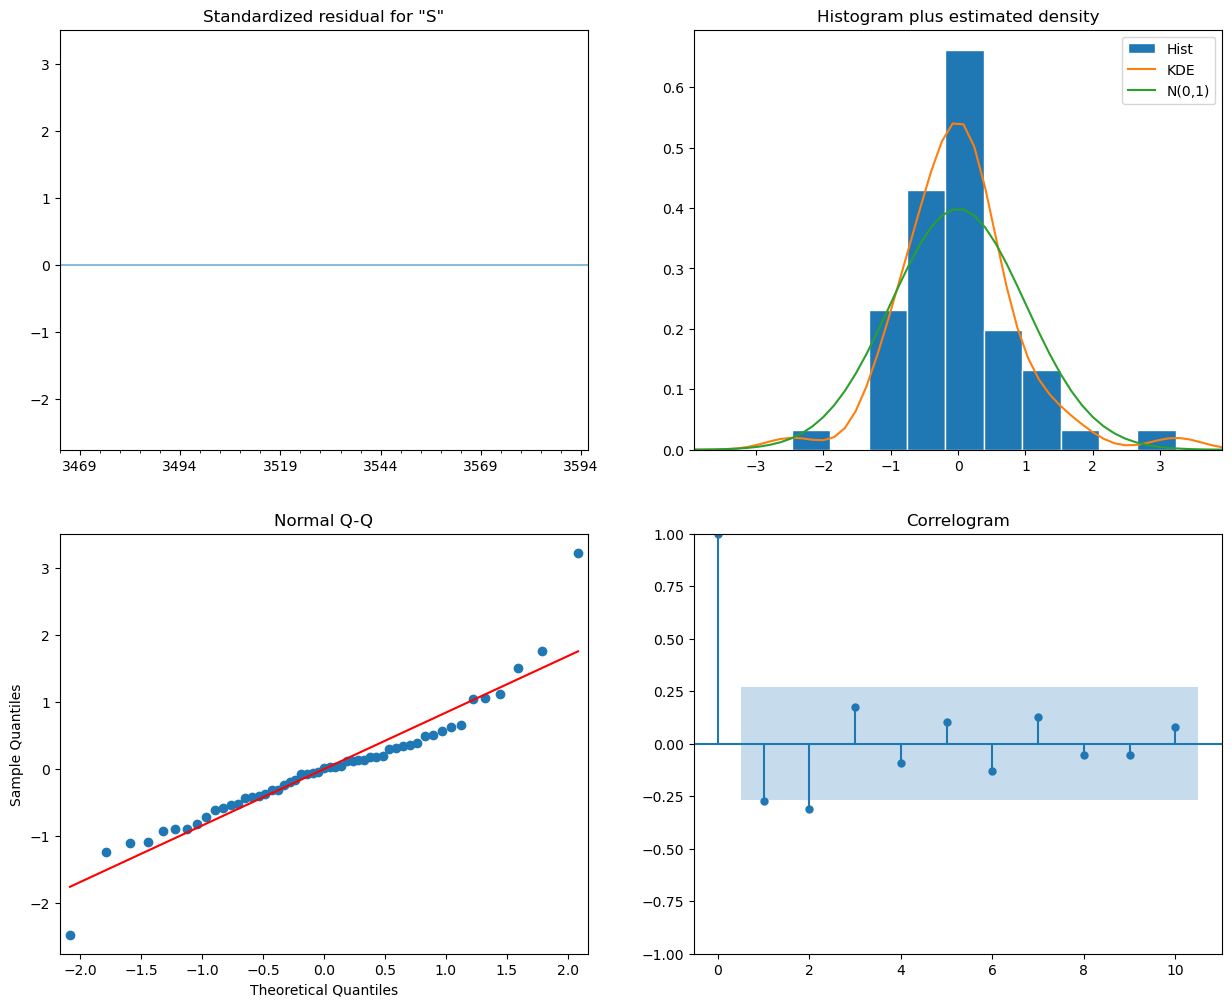

In [58]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [59]:
forecast_test_sarima=sarima_model.predict(start=54,end=59,dynamic=True)

In [60]:
sales_d['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product D')

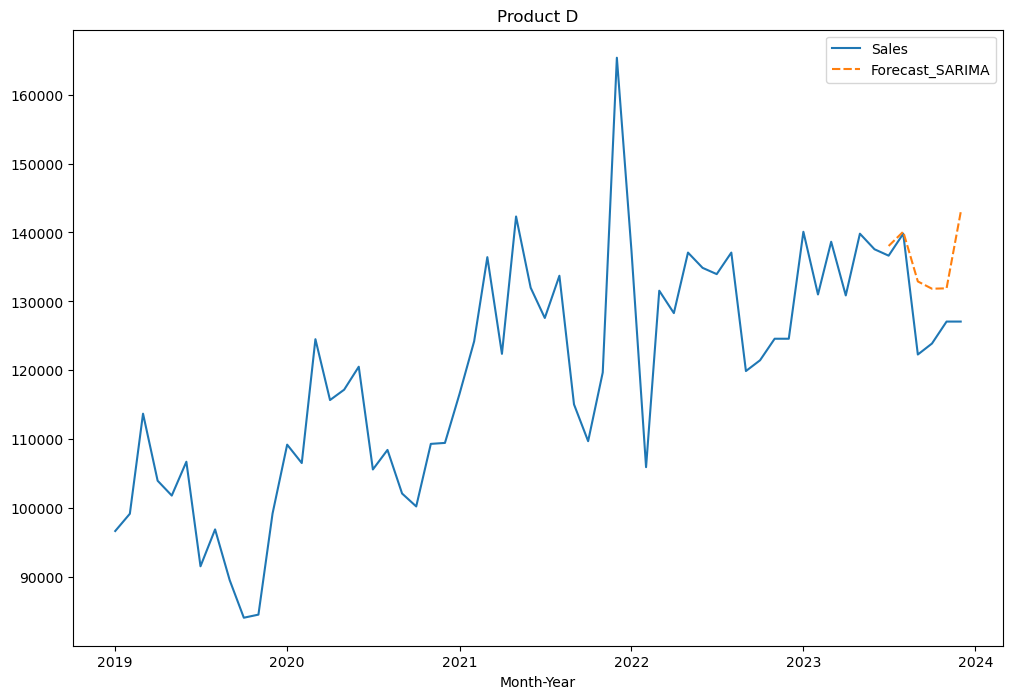

In [61]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_SARIMA']])
plt.title('Product D')

In [62]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 6823.326
MAPE - SARIMA: 0.054
MSE - SARIMA: 75458872.043
RMSE - SARIMA: 8686.707


# AUTO-ARIMA

In [41]:
import pmdarima as pm

In [42]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,max_q=3,
                          start_P=0, D=0, start_Q=0, max_P=5 ,max_Q=4 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1156.894, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1156.779, Time=0.07 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1154.703, Time=0.20 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=1153.315, Time=0.53 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=1154.295, Time=3.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1156.155, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1157.576, Time=0.07 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1151.894, Time=0.47 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=1153.888, Time=1.00 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=1155.849, Time=6.09 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1155.927, Time=0.15 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1153.113, Time=0.33 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1153.886, Time=0.54 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=1155.852, Time=3.57 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=1154.242, Time=0.51

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True)

In [43]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -567.870
Date:                                 Thu, 09 May 2024   AIC                           1149.741
Time:                                         16:45:00   BIC                           1163.533
Sample:                                     01-01-2019   HQIC                          1155.045
                                          - 06-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1198.7392   1324.381      0.905      0.365   -1397.000    3794.478
ar.L1          0.5341      0.201      2.655      0.008       0.140       0.928
ma.L1         -0.8416      0.184     -4.565      0.000      -1.203      -0.480
ar.S.L12      -0.7466      0.671     -1.113      0.266      -2.062       0.568
ma.S.L12       1.0321      0.790      1.307      0.191      -0.516       2.580
ma.S.L24       0.4667      0.228      2.043      0.041       0.019       0.915
sigma2      1.477e+08      0.008   1.76e+10      0.000    1.48e+08    1.48e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 6.79
Prob(Q):                              0.69   Prob(JB):                         0.03
Heteroskedasticity (H):               0.74   Skew:                             0.42
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.47e+26. Standard errors may be unstable.
"""

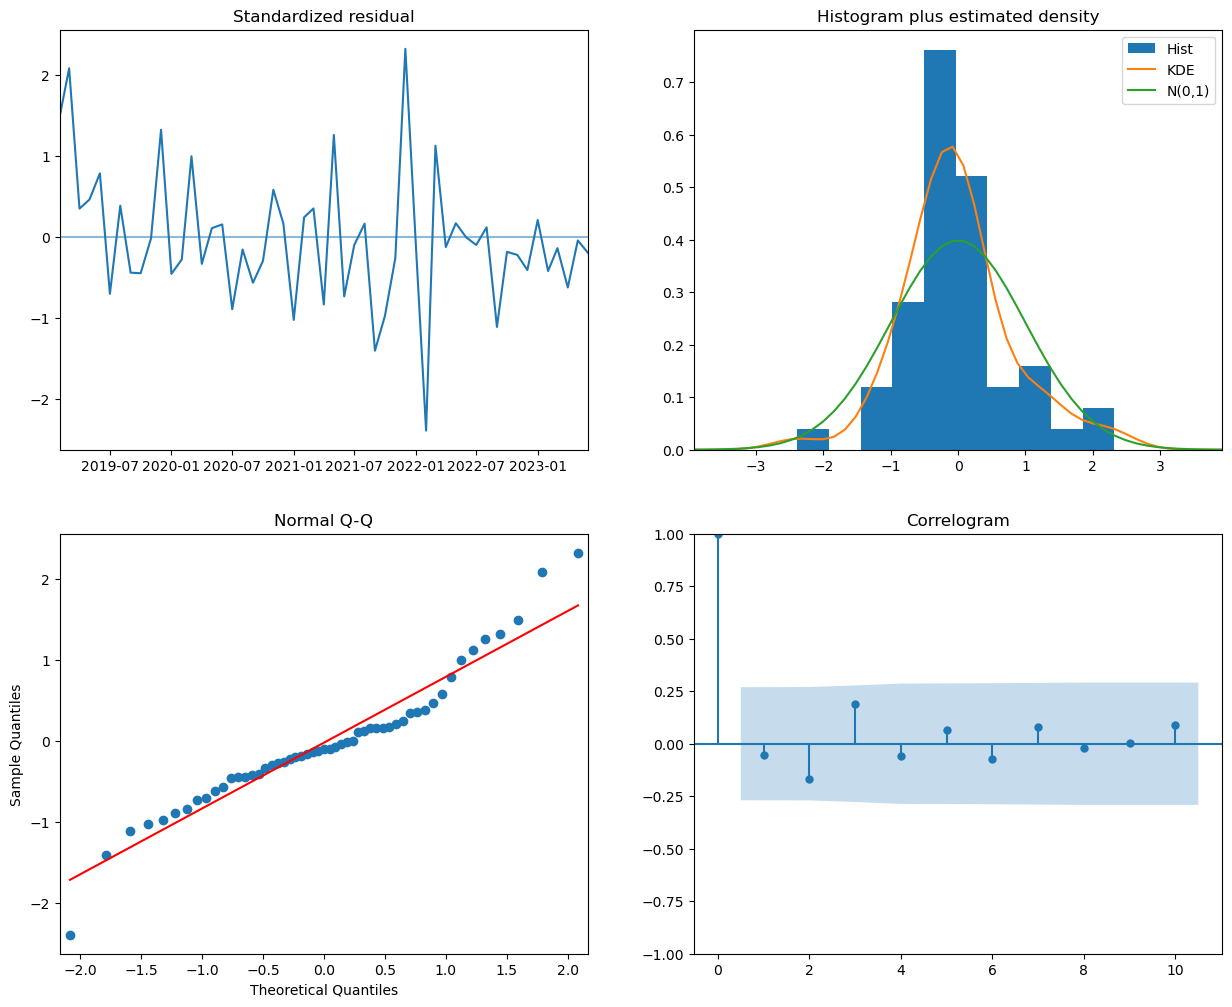

In [44]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [45]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_d['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_d[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product D')

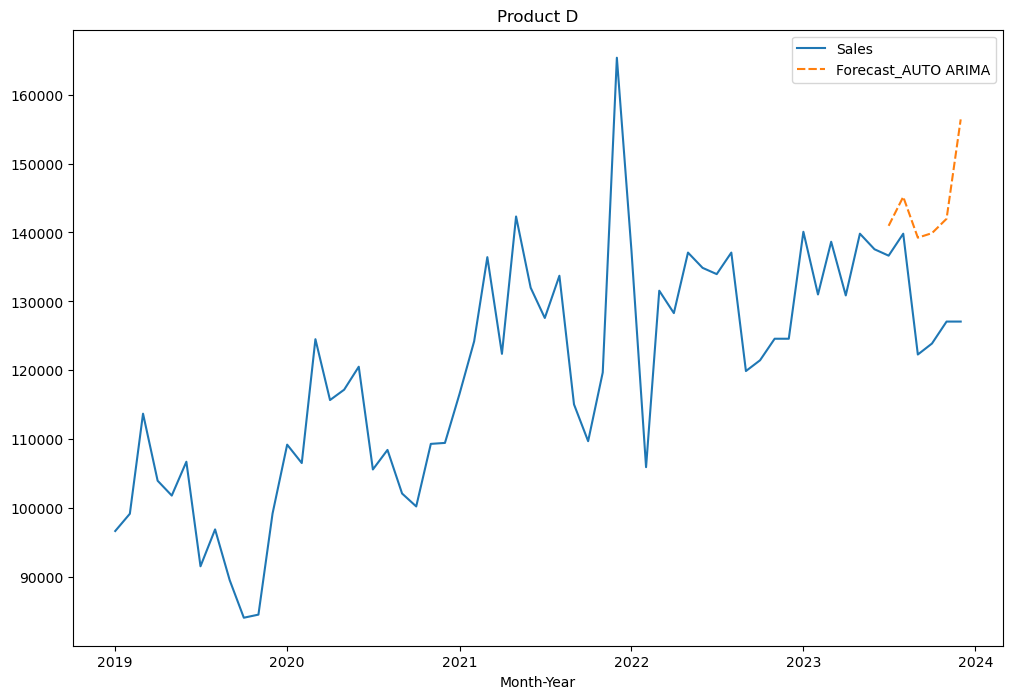

In [46]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product D')

In [47]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 14483.883497107056
MAPE - AUTO ARIMA: 0.11435190241712241
MSE - AUTO ARIMA: 279061071.67597157
RMSE - AUTO ARIMA: 16705.121121260137


In [48]:
sales_d.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,140104,NaN,NaN,NaN
2023-02-01,131006,NaN,NaN,NaN
2023-03-01,138656,NaN,NaN,NaN
2023-04-01,130866,NaN,NaN,NaN
2023-05-01,139824,NaN,NaN,NaN
2023-06-01,137565,NaN,NaN,NaN
2023-07-01,136637,137565.0,135465.747229,140967.876396
2023-08-01,139824,137565.0,138854.528775,145176.252583
2023-09-01,122293,137565.0,127879.377322,139245.776511


In [49]:
sales_d.mean()

Sales                  119558.133333
Forecast_ARIMA         137565.000000
Forecast_SARIMA        132495.003164
Forecast_AUTO ARIMA    143948.716830
dtype: float64

In [50]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,8853.166667,0.070559,1.077347e+08,10379.531902
AUTO ARIMA,14483.883497,0.114352,2.790611e+08,16705.121121
SEASONAL ARIMA,3859.539042,0.030514,3.362324e+07,5798.555185


# TESTING

In [17]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1156.894, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1156.779, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1154.703, Time=0.25 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1156.155, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1157.576, Time=0.09 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1151.894, Time=0.40 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1155.927, Time=0.14 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1153.113, Time=0.33 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1153.886, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1157.057, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1156.999, Time=0.08 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1154.166, Time=0.29 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1156.400, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1158.004, Time=0.16 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1149.803, Time=0.49

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True)

In [18]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -567.870
Date:                                 Wed, 08 May 2024   AIC                           1149.741
Time:                                         19:02:43   BIC                           1163.533
Sample:                                     01-01-2019   HQIC                          1155.045
                                          - 06-01-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1198.7392   1324.381      0.905      0.365   -1397.000    3794.478
ar.L1          0.5341      0.201      2.655      0.008       0.140       0.928
ma.L1         -0.8416      0.184     -4.565      0.000      -1.203      -0.480
ar.S.L12      -0.7466      0.671     -1.113      0.266      -2.062       0.568
ma.S.L12       1.0321      0.790      1.307      0.191      -0.516       2.580
ma.S.L24       0.4667      0.228      2.043      0.041       0.019       0.915
sigma2      1.477e+08      0.008   1.76e+10      0.000    1.48e+08    1.48e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 6.79
Prob(Q):                              0.69   Prob(JB):                         0.03
Heteroskedasticity (H):               0.74   Skew:                             0.42
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.47e+26. Standard errors may be unstable.
"""

In [19]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_d['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product D')

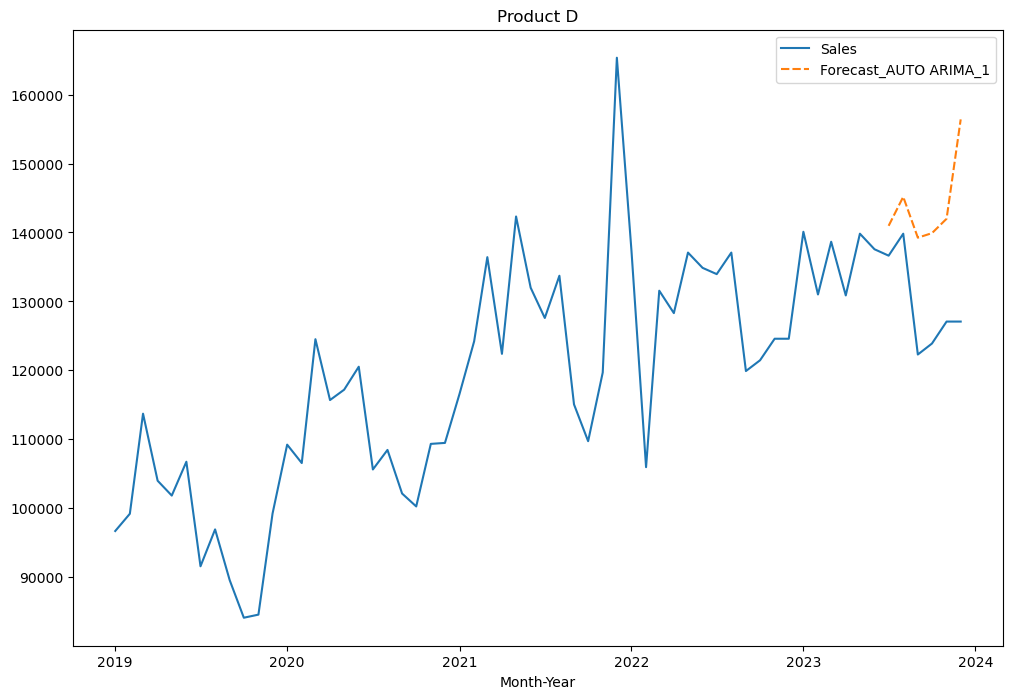

In [20]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_d[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product D')

In [21]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 14483.883497107056
MAPE - AUTO ARIMA: 0.11435190241712241
MSE - AUTO ARIMA: 279061071.67597157
RMSE - AUTO ARIMA: 16705.121121260137
